In [31]:
#Automating gene plotting
#Need a table of gene/ontology with mean RZS score

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Timp3"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/merged_by_celltype/"
rzs_score_path = "/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/analysis/gene_ontology_rzs.csv"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"correct_strand_only.png",sep="")
tracks = list()

df = fread(rzs_score_path)
df = df[gene == gene_name]
df = df[order(mean_rzs)]

cell_types = df$ontology
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
        
    cov_track = AlignmentsTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        name = ct,
        chromosome = chr,
        #col = colors[[i]],
        #fill = colors[[i]],
        strand = gene_strand,
        legend = TRUE,
        type = "coverage",
        window = -1,
        windowSize = 1,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

png 
  2

In [18]:
#TIMP3 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Timp3"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

cell_types = c("L6_IT","L23_IT","Astro","SMC")
colors = c("#2777B1","#FF7F2B","#9667BA","#3EBECD")

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"correct_strand_only.png",sep="")
tracks = list()


                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
        
    cov_track = AlignmentsTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        name = ct,
        chromosome = chr,
        col = colors[[i]],
        fill = colors[[i]],
        strand = gene_strand,
        legend = TRUE,
        type = "coverage",
        #aggregation = "sum",
        window = -1,
        windowSize = 1,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

png 
  2

In [8]:
gene_row$end-gene_row$start

[1] 49134

In [34]:
chr

[1] "chr10"

png 
  3

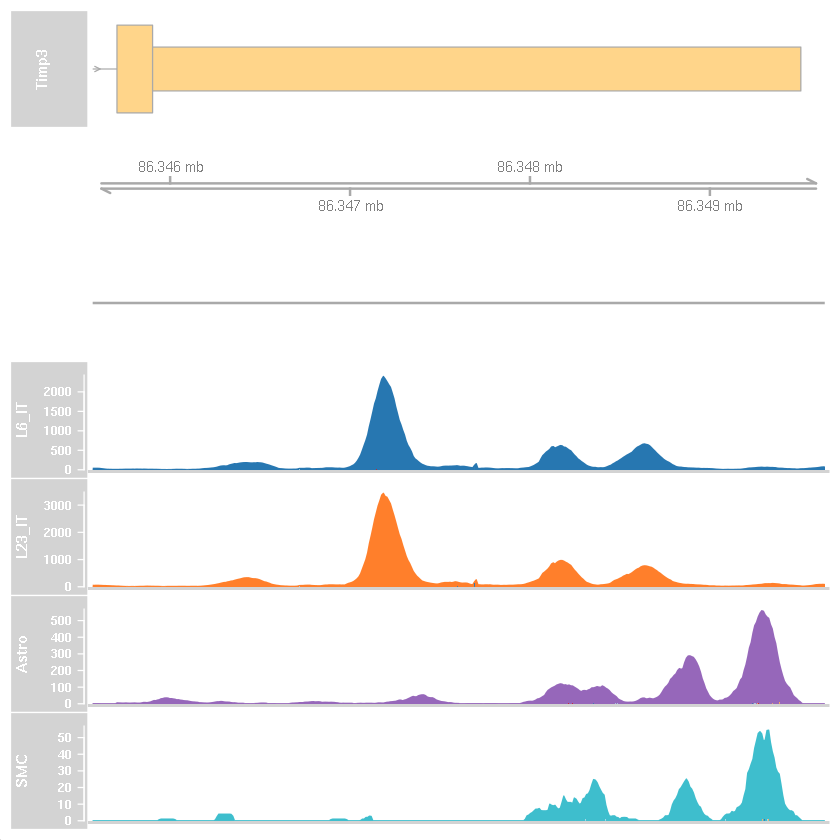

In [26]:
#TIMP3 3' UTR ZOOM
library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Timp3"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

cell_types = c("L6_IT","L23_IT","Astro","SMC")
colors = c("#2777B1","#FF7F2B","#9667BA","#3EBECD")

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/merged_by_celltype/"        
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = 86345570
window_end   = 86349639

gene_strand  = gene_row$strand
outfile = paste(gene_name,"_3utr.png",sep="")
tracks = list()


                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

gTrack <- GenomeAxisTrack()
tracks = append(tracks,gTrack)


####################################
#                                  #
#                                  #
#        Sequence Track            #
#                                  #
#                                  #
####################################
#seqTrack <- SequenceTrack("mm10.fa", chromosome = chr)
#tracks = append(tracks,seqTrack)

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
        
    cov_track = AlignmentsTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        name = ct,
        chromosome = chr,
        col = colors[[i]],
        fill = colors[[i]],
        strand = gene_strand,
        legend = TRUE,
        type = "coverage",
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
#png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()


In [33]:
#TIMP3 3' UTR First peak zoom
library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Timp3"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

cell_types = c("L6_IT","L23_IT","Astro","SMC")
colors = c("#2777B1","#FF7F2B","#9667BA","#3EBECD")

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/merged_by_celltype/"        
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = 86347150
window_end   = 86347200

gene_strand  = gene_row$strand
outfile = paste(gene_name,"_3utr.png",sep="")
tracks = list()


                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

gTrack <- GenomeAxisTrack()
tracks = append(tracks,gTrack)


####################################
#                                  #
#                                  #
#        Sequence Track            #
#                                  #
#                                  #
####################################
seqTrack <- SequenceTrack("mm10.fa", chromosome = chr)
tracks = append(tracks,seqTrack)

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
        
    cov_track = AlignmentsTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        name = ct,
        chromosome = chr,
        col = colors[[i]],
        fill = colors[[i]],
        strand = gene_strand,
        legend = TRUE,
        type = "coverage",
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()


png 
  2

In [1]:
library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Cbln2"
cell_types = c("Vip","L5 IT","L6 IT")
colors = c("#2777B1","#9467BD","#7F7F7F")

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/merged_by_celltype/"        
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]


chr = gene_row[, get("#chr")]
window_start = gene_row$start
window_end   = gene_row$end
gene_strand  = gene_row$strand
outfile = paste(gene_name,"correct_strand_only.png",sep="")
tracks = list()


                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
        
    cov_track = AlignmentsTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        name = ct,
        chromosome = chr,
        col = colors[[i]],
        fill = colors[[i]],
        strand = gene_strand,
        legend = TRUE,
        type = "coverage",
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = "UTR",
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

png 
  2

In [8]:
#C1ql3 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "C1ql3"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"

cell_types = c("L5_IT","Sst","L23_IT","L6_IT")
colors = c(blue_color,orange_color,green_color,red_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "Sst"
[1] "WORKING ON CT"
[1] "L23_IT"
[1] "WORKING ON CT"
[1] "L6_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [9]:
#Col15a1 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Col15a1"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"

cell_types = c("L5_IT","Vip","L6b")
colors = c(blue_color,orange_color,green_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "Vip"
[1] "WORKING ON CT"
[1] "L6b"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [10]:
#Ptpru ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Ptpru"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"

cell_types = c("L23_IT","L5_IT","L6_CT","Lamp5")
colors = c(blue_color,orange_color,purple_color,grey_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L23_IT"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "L6_CT"
[1] "WORKING ON CT"
[1] "Lamp5"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [12]:
#Rxfp2 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Rxfp2"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"

cell_types = c("L56_NP","L5_IT")
colors = c(blue_color,orange_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L56_NP"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [14]:
#Adra1b ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Adra1b"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"

cell_types = c("L5_ET","L5_IT","Vip","L56_NP")
colors = c(blue_color,orange_color,grey_color,light_green_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L5_ET"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "Vip"
[1] "WORKING ON CT"
[1] "L56_NP"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [15]:
#Cbln2 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Cbln2"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"

cell_types = c("Vip","L56_NP","L6_CT","L6_IT")
colors = c(blue_color,orange_color,red_color,grey_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Vip"
[1] "WORKING ON CT"
[1] "L56_NP"
[1] "WORKING ON CT"
[1] "L6_CT"
[1] "WORKING ON CT"
[1] "L6_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [2]:
#Barx2 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Barx2"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"

cell_types = c("Pvalb","L23_IT")
colors = c(blue_color,orange_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Pvalb"
[1] "WORKING ON CT"
[1] "L23_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [3]:
window_start

[1] 31842673

In [4]:
window_end

[1] 31916833

In [26]:
#Barx2 Zoom

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Barx2"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"

cell_types = c("Pvalb","L23_IT")
colors = c(blue_color,orange_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
#window_start = round(gene_row$start-gene_buffer)
#window_end   = round(gene_row$end+gene_buffer)
window_start = 31845673
window_end =   31847673
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual_zoom.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "l",
        name = ct,
        chromosome = chr,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
        window = -1,
        windowSize = 1,
        aggregation = "sum",
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Pvalb"
[1] "WORKING ON CT"
[1] "L23_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [3]:
#Fezf2 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Fezf2"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"

cell_types = c("L5_ET","L5_IT","L6b")
colors = c(blue_color,orange_color,purple_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L5_ET"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "L6b"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [4]:
#Hs3st5 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Hs3st5"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"

cell_types = c("L5_IT","L6_IT","L5_ET")
colors = c(blue_color,orange_color,green_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "L6_IT"
[1] "WORKING ON CT"
[1] "L5_ET"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [5]:
#Itgb8 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Itgb8"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("Oligo","L23_IT","Astro","L6_CT")
colors = c(blue_color,orange_color,purple_color,pink_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Oligo"
[1] "WORKING ON CT"
[1] "L23_IT"
[1] "WORKING ON CT"
[1] "Astro"
[1] "WORKING ON CT"
[1] "L6_CT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [6]:
#Phactr2 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Phactr2"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("Endo","Astro","L5_IT")
colors = c(blue_color,orange_color,purple_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Endo"
[1] "WORKING ON CT"
[1] "Astro"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [7]:
#Prdm8 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Prdm8"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("L23_IT","L6_CT","L5_IT")
colors = c(blue_color,orange_color,green_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L23_IT"
[1] "WORKING ON CT"
[1] "L6_CT"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [8]:
#Prss23 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Prss23"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("L6b","L5_IT","L6_IT")
colors = c(blue_color,green_color,purple_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L6b"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "L6_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [9]:
#Rgs5 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Rgs5"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("Endo","L56_NP","L6_CT")
colors = c(orange_color,green_color,purple_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Endo"
[1] "WORKING ON CT"
[1] "L56_NP"
[1] "WORKING ON CT"
[1] "L6_CT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [16]:
txdb = loadDb(txdb_path)
any(genes(txdb) == "Slc17a6")

ERROR: Error in asMethod(object, strict = FALSE): The character vector to convert to a GRanges object must contain
  strings of the form "chr:start-end" or "chr:start-end:strand", with end
  >= start - 1, or "chr:pos" or "chr:pos:strand". For example:
  "chr1:2501-2900", "chr1:2501-2900:+", or "chr1:740". Note that ".." is
  a valid alternate start/end separator. Strand can be "+", "-", "*", or
  missing.


In [17]:
#Slc17a6 ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Slc17a6"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("L5_IT","L56_NP","L23_IT")
colors = c(orange_color,green_color,red_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "L56_NP"
[1] "WORKING ON CT"
[1] "L23_IT"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [18]:
#Ubash3b ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Ubash3b"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("Sst","L5_IT","Vip")
colors = c(blue_color,green_color,pink_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Sst"
[1] "WORKING ON CT"
[1] "L5_IT"
[1] "WORKING ON CT"
[1] "Vip"
[1] "RIGHT BEFORE PLOTTING"


png 
  2

In [19]:
#Unc5b ENTIRE GENE

library(Gviz)
library(GenomicFeatures)
library(data.table)

options(ucscChromosomeNames=FALSE)

#Manually setting gene and cell-types to plot
gene_name = "Unc5b"
gene_padding = 0.05 #how much to pad upstream and downstream of the gene

blue_color = "#2777B4"
orange_color = "#F67F11"
green_color = "#2EA02D"
red_color = "#D62727"
purple_color = "#9467BD"
grey_color = "#7F7F7F"
light_green_color = "#BCBD22"
pink_color = "#E377C2"

cell_types = c("Oligo")
colors = c(orange_color)

txdb_path = "txdb.mm10.sqlite"
bed_path = "MERFISH_genes.bed"
bam_stem = "/oak/stanford/groups/horence/rob/MERFISH_scRNAseq/merged_by_celltype/"
bam_paths = Sys.glob(paste(bam_stem,"*.bam",sep=""))
                                         
gene_locs = fread(bed_path)
gene_row = gene_locs[gene == gene_name]

gene_buffer = (gene_row$end-gene_row$start)*gene_padding

chr = gene_row[, get("#chr")]
window_start = round(gene_row$start-gene_buffer)
window_end   = round(gene_row$end+gene_buffer)
gene_strand  = gene_row$strand
outfile = paste(gene_name,"_manual.png",sep="")
tracks = list()

print("ABOUT TO MAKE GENE TRACK")
                                         
####################################
#                                  #
#                                  #
#            Gene Track            #
#                                  #
#                                  #
####################################
txdb = loadDb(txdb_path)

geneTrack = GeneRegionTrack(
    range = txdb,
    chromosome = chr,
    start = window_start,
    end = window_end,
    #strand = gene_strand,
    name = gene_name,
)

geneTrack <- geneTrack[
    gene(geneTrack) == gene_name
]
tracks = append(tracks,geneTrack)

print("ABOUT TO MAKE DATA TRACKS")

####################################
#                                  #
#                                  #
#            Data Tracks           #
#                                  #
#                                  #
####################################
data_tracks = list()

for(i in 1:length(cell_types)){
    print("WORKING ON CT")
    ct = cell_types[[i]]
    ct = sub(" ","_",ct)
    print(ct)
        
    cov_track = DataTrack(
        range = paste(bam_stem,ct,".bam",sep=""),
        type = "a",
        name = ct,
        chromosome = chr,
        start = window_start,
        end = window_end,
        col = colors[[i]],
        fill = colors[[i]],
        stream = TRUE,
    )
    data_tracks = append(data_tracks,cov_track)
}
tracks = append(tracks, data_tracks)

####################################
#                                  #
#                                  #
#            Plotting              #
#                                  #
#                                  #
####################################
png(outfile, width = 800, height = 400)
par(mar=c(5,6,4,1)+.1)

print("RIGHT BEFORE PLOTTING")

plotTracks(
    tracks,
    sizes = rep(1/length(tracks),length(tracks)), #give equal vertical space to each plot
    from = window_start, 
    to = window_end,
    thinBoxFeature = c("utr3","utr5"),
    collapse = F,
    transcriptAnnotation = "gene",
    fontcolor.exon = "black"
)

dev.off()

[1] "ABOUT TO MAKE GENE TRACK"
[1] "ABOUT TO MAKE DATA TRACKS"
[1] "WORKING ON CT"
[1] "Oligo"
[1] "RIGHT BEFORE PLOTTING"


png 
  2